# Trabalho da Disciplina de Programação em R da Pós Graduação de Ciência de Dados da Unicarioca
Professor da disciplina: Sérgio Monteiro, DSc

Aluno: Gustavo Rodrigues Carvalho

Matrícula: 2019100645

https://www.linkedin.com/in/gustavorcarvalho

https://github.com/Gustsbra


**Objetivo do trabalho**: Realizar uma análise das ações de uma empresa listada na B3 (Bovespa), com base em histograma, indicadores técnicos e padrões de candlestick. Além disso, realizar a integração de uma IA generativa, neste caso, o Gemini da Google, para permitir a inserção de comandos na busca de informações relevantes sobre a ação e sobre a empresa no período analisado, possibilitanto um melhor entendimento dos gráficos apresentados e identificação de tendências.

# Definições iniciais do projeto

In [1]:
# Instalando pacotes necessários
install.packages(c("quantmod", "TTR"))
install.packages("httr")
install.packages("jsonlite")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Carregar pacotes
library(quantmod)
library(TTR)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [47]:
# Criando uma função para integrar o Gemini do Google ao código e buscar informações relevantes sobre a ação da empresa a ser analisada
# https://www.listendata.com/2023/12/google-gemini-r.html

library(httr)
library(jsonlite)

# Function
gemini <- function(prompt,
                 temperature=0.5,
                 max_output_tokens=1024,
                 api_key=Sys.getenv("GEMINI_API_KEY"),
                 model = "gemini-pro") {

  if(nchar(api_key)<1) {
    api_key <- readline("Insira a chave da API do Google AI Studio aqui:  ")
    Sys.setenv(GEMINI_API_KEY = api_key)
  }

  model_query <- paste0(model, ":generateContent")

  response <- POST(
    url = paste0("https://generativelanguage.googleapis.com/v1beta/models/", model_query),
    query = list(key = api_key),
    content_type_json(),
    encode = "json",
    body = list(
      contents = list(
        parts = list(
          list(text = prompt)
        )),
      generationConfig = list(
        temperature = temperature,
        maxOutputTokens = max_output_tokens
      )
    )
  )

  if(response$status_code>200) {
    stop(paste("Error - ", content(response)$error$message))
  }

  candidates <- content(response)$candidates
  outputs <- unlist(lapply(candidates, function(candidate) candidate$content$parts))

  return(outputs)

}

In [4]:
#Função criada para definir o tamanho da área de plotagem dos gráficos
set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width = width_choice, repr.plot.height = height_choice)
}
# Definindo o tamanho da área do plot
set_plot_dimensions(40, 10)

In [5]:
# Definindo o período desejado

start_date <- "2019-01-01"
end_date <- Sys.Date()  # Data atual

# Análise de ações da B3
Para definir o símbolo da ação que buscamos, podemos acessar:

Site da B3 - https://www.b3.com.br/pt_br/produtos-e-servicos/negociacao/renda-variavel/empresas-listadas.htm

Site do Yahoo Finance - https://finance.yahoo.com/lookup

Por exemplo, para ações da empresa Vale listadas na B3, temos o ticker VALE3.SA

In [6]:
# Definir símbolo da ação
ticker <- "VALE3.SA"

In [7]:
# Obter dados históricos
getSymbols(ticker, src = "yahoo", from = start_date, to = end_date)

[1] "VALE3.SA"

In [8]:
# Exibindo o dataframe dos preços ajustados
df_ticker <- na.omit(Ad(get(ticker)))
head(df_ticker)

           VALE3.SA.Adjusted
2019-01-02          33.35790
2019-01-03          31.99328
2019-01-04          34.07612
2019-01-07          33.89330
2019-01-08          34.21976
2019-01-09          35.05549

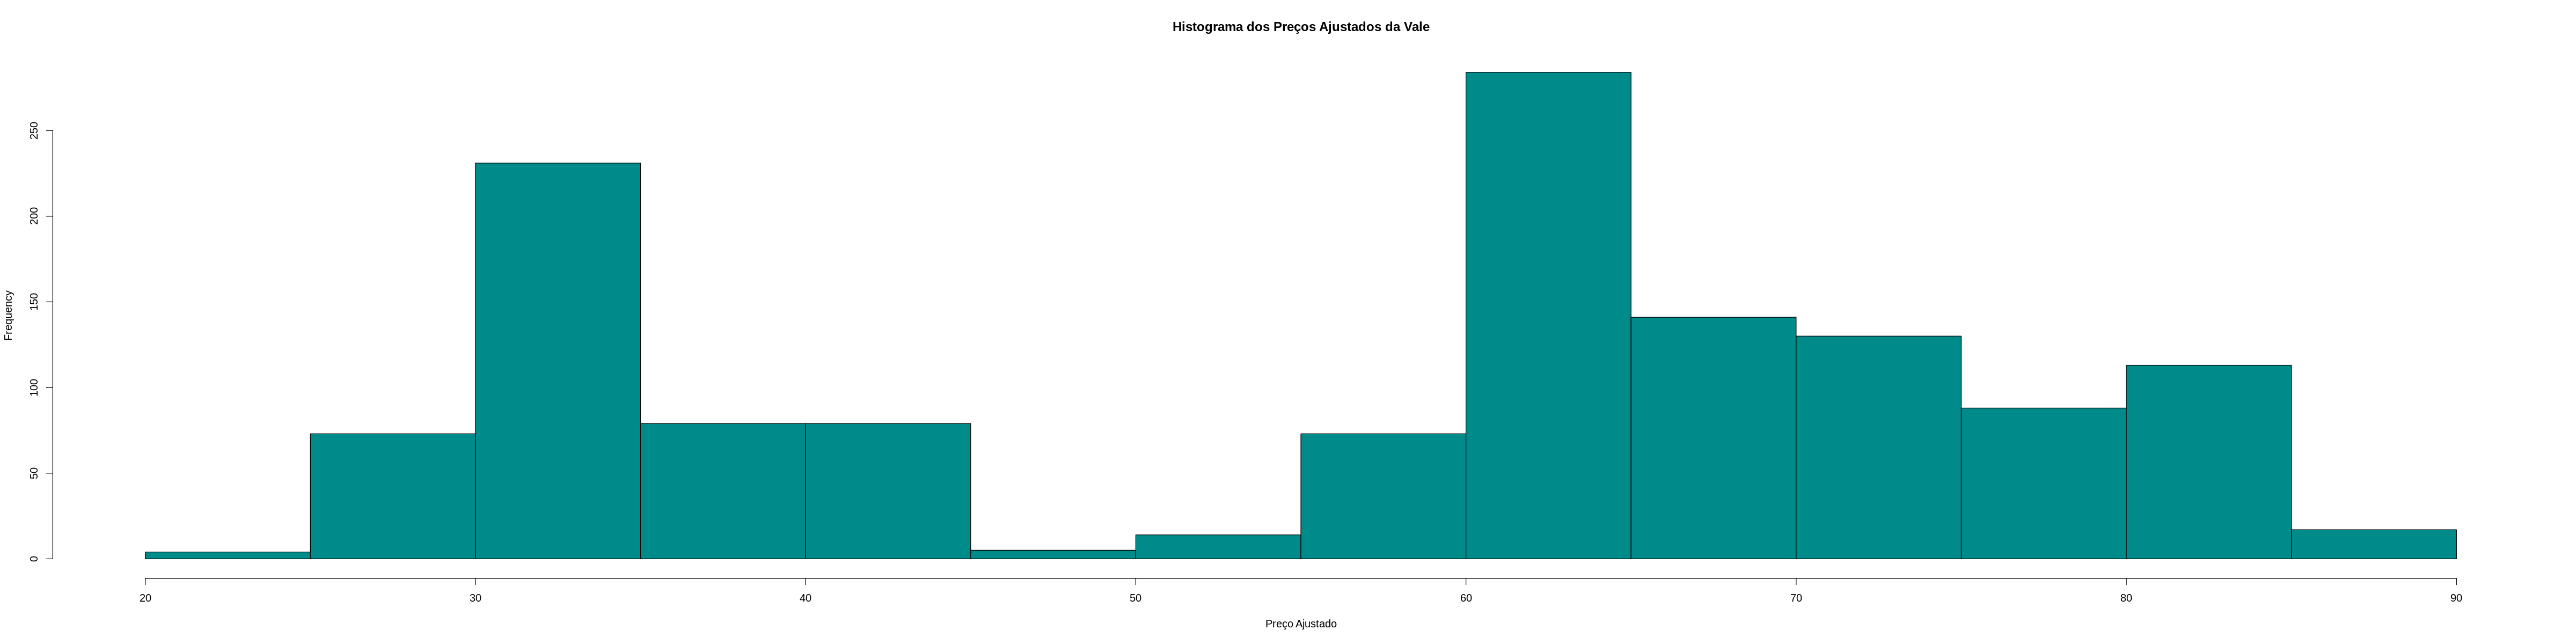

In [9]:
# Criando o histograma dos preços ajustados
hist(df_ticker, main = "Histograma dos Preços Ajustados da Vale", xlab = "Preço Ajustado", col = "cyan4")

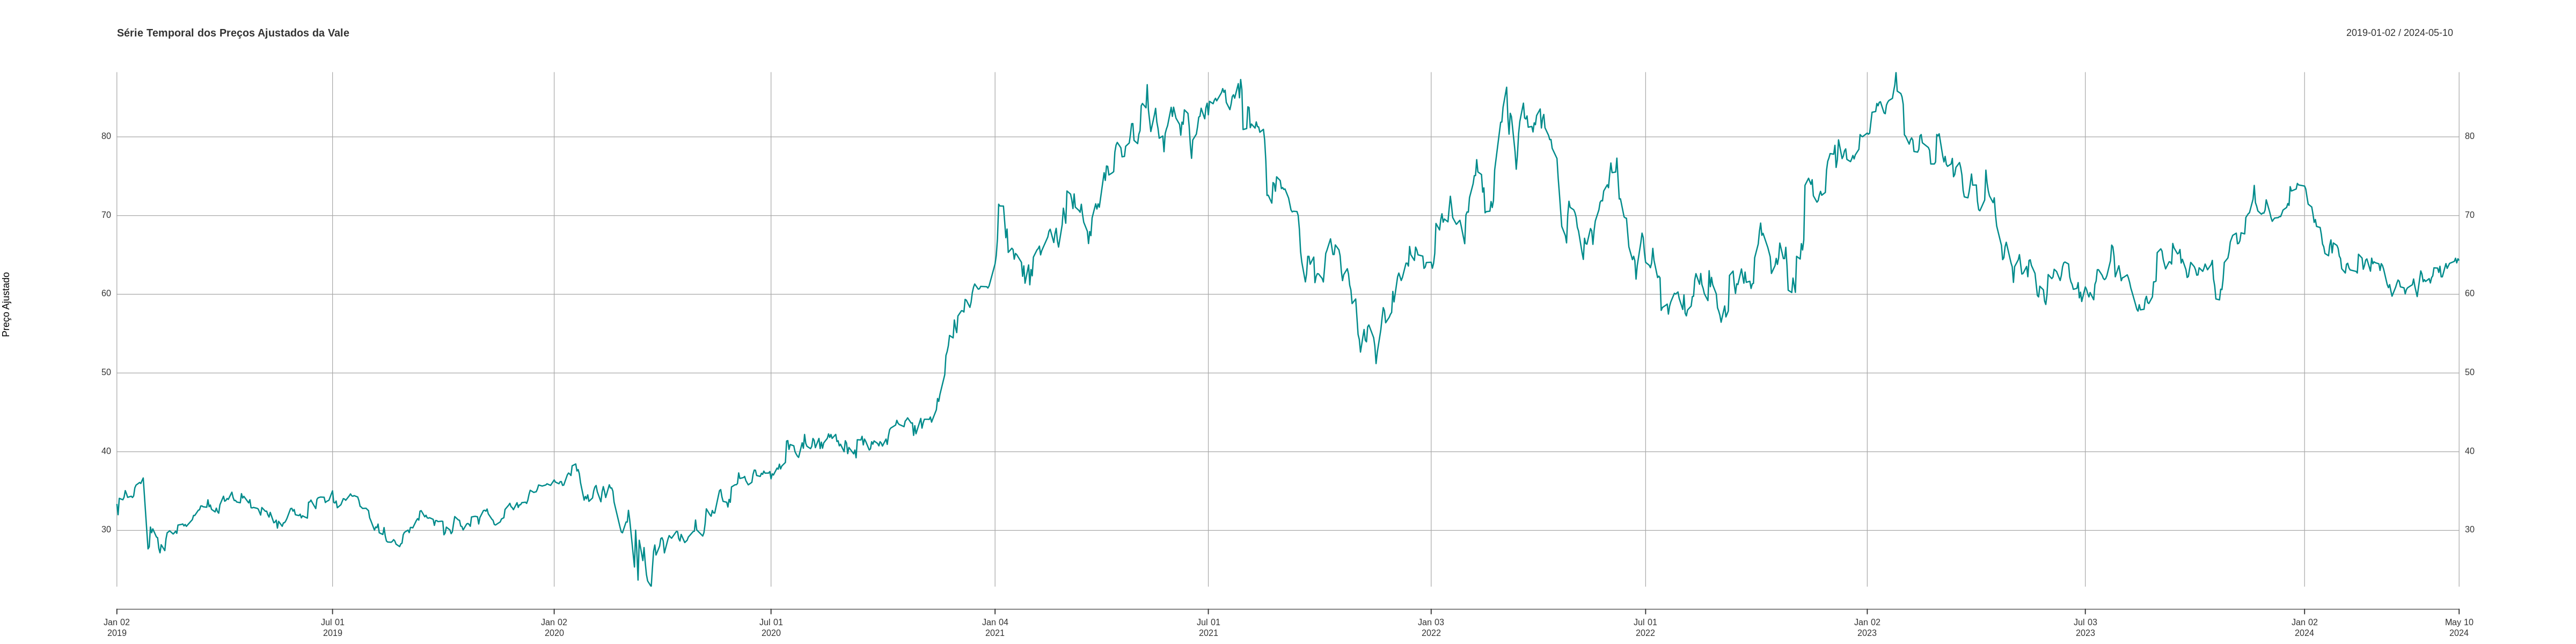

In [10]:
# Criando a série temporal dos preços ajustados
plot(df_ticker, main = "Série Temporal dos Preços Ajustados da Vale", ylab = "Preço Ajustado", col = "cyan4")

# **Análise dos momentos de compra e venda**

In [11]:
# Verificando a estrutura dos dados baixados
str(VALE3.SA)

# Extraindo os preços ajustados
precos_ajustados <- Cl(VALE3.SA)

An xts object on 2019-01-02 / 2024-05-10 containing: 
  Data:    double [1331, 6]
  Columns: VALE3.SA.Open, VALE3.SA.High, VALE3.SA.Low, VALE3.SA.Close, VALE3.SA.Volume ... with 1 more column
  Index:   Date [1331] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2024-05-12 11:54:07"


In [12]:
# Calculando médias móveis de curto e longo prazo
VALE3.SA$SMA20 <- SMA(precos_ajustados, n = 20)
VALE3.SA$SMA50 <- SMA(precos_ajustados, n = 50)

In [13]:
# Calculando os envelopes de Bollinger
n <- 20  # Período para os envelopes de Bollinger
VALE3.SA$SDB <- BBands(precos_ajustados, n = n, maType = "SMA", sd = 2)$dn
VALE3.SA$SDT <- BBands(precos_ajustados, n = n, maType = "SMA", sd = 2)$up

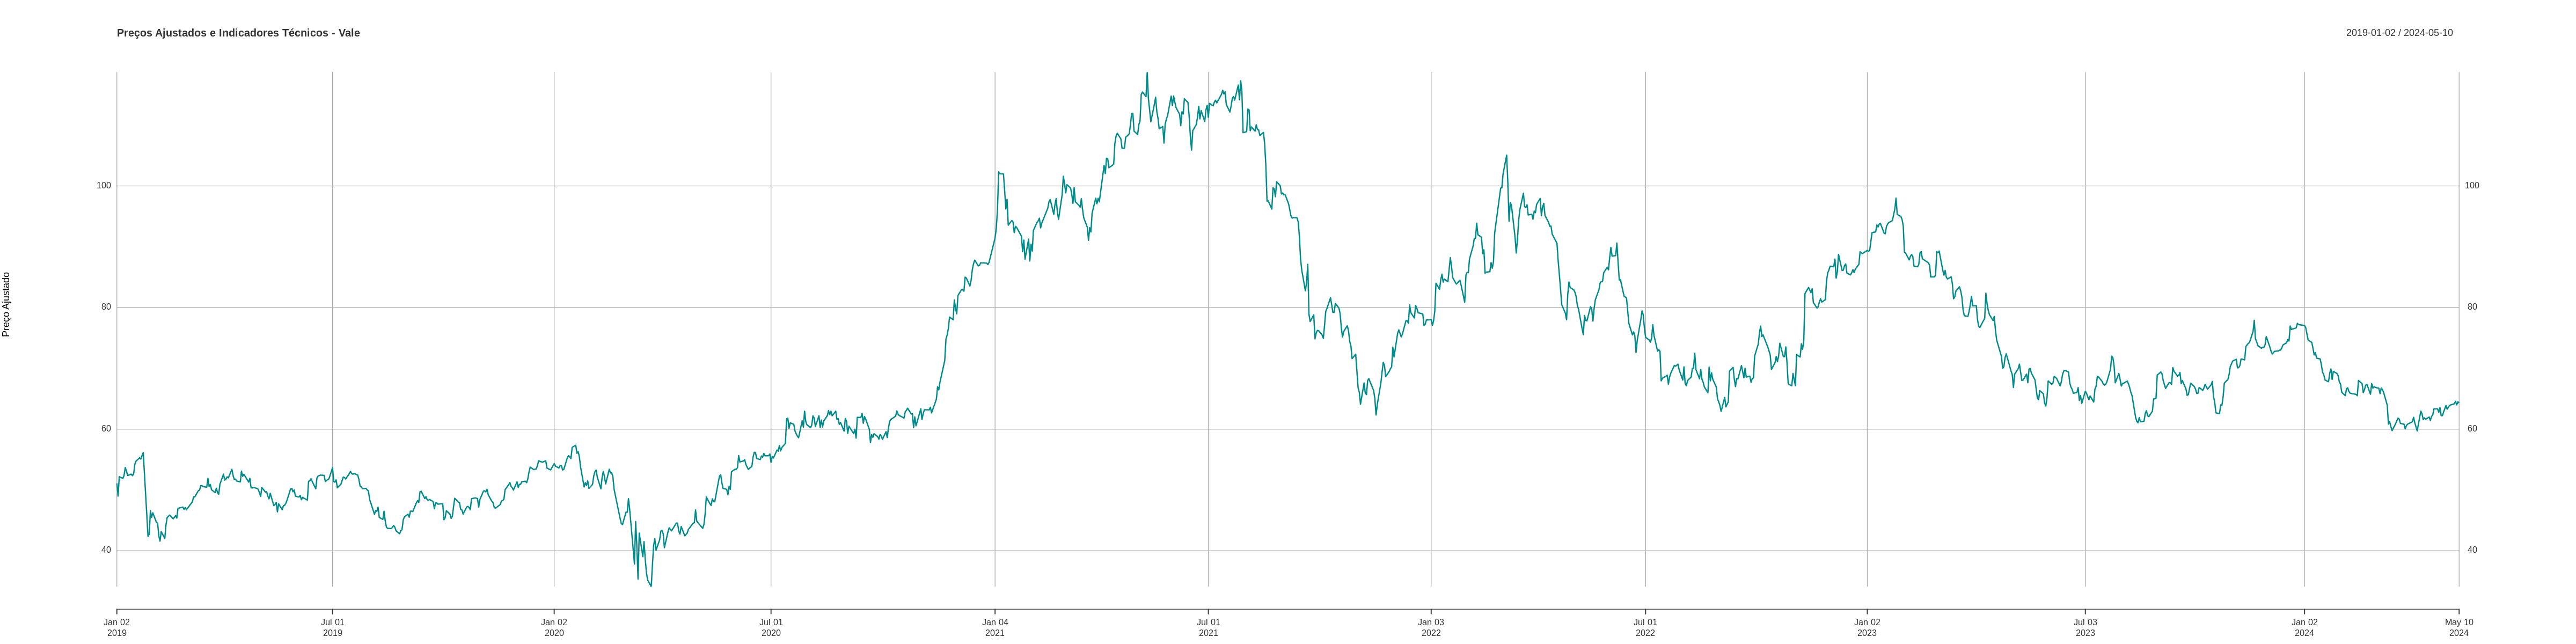

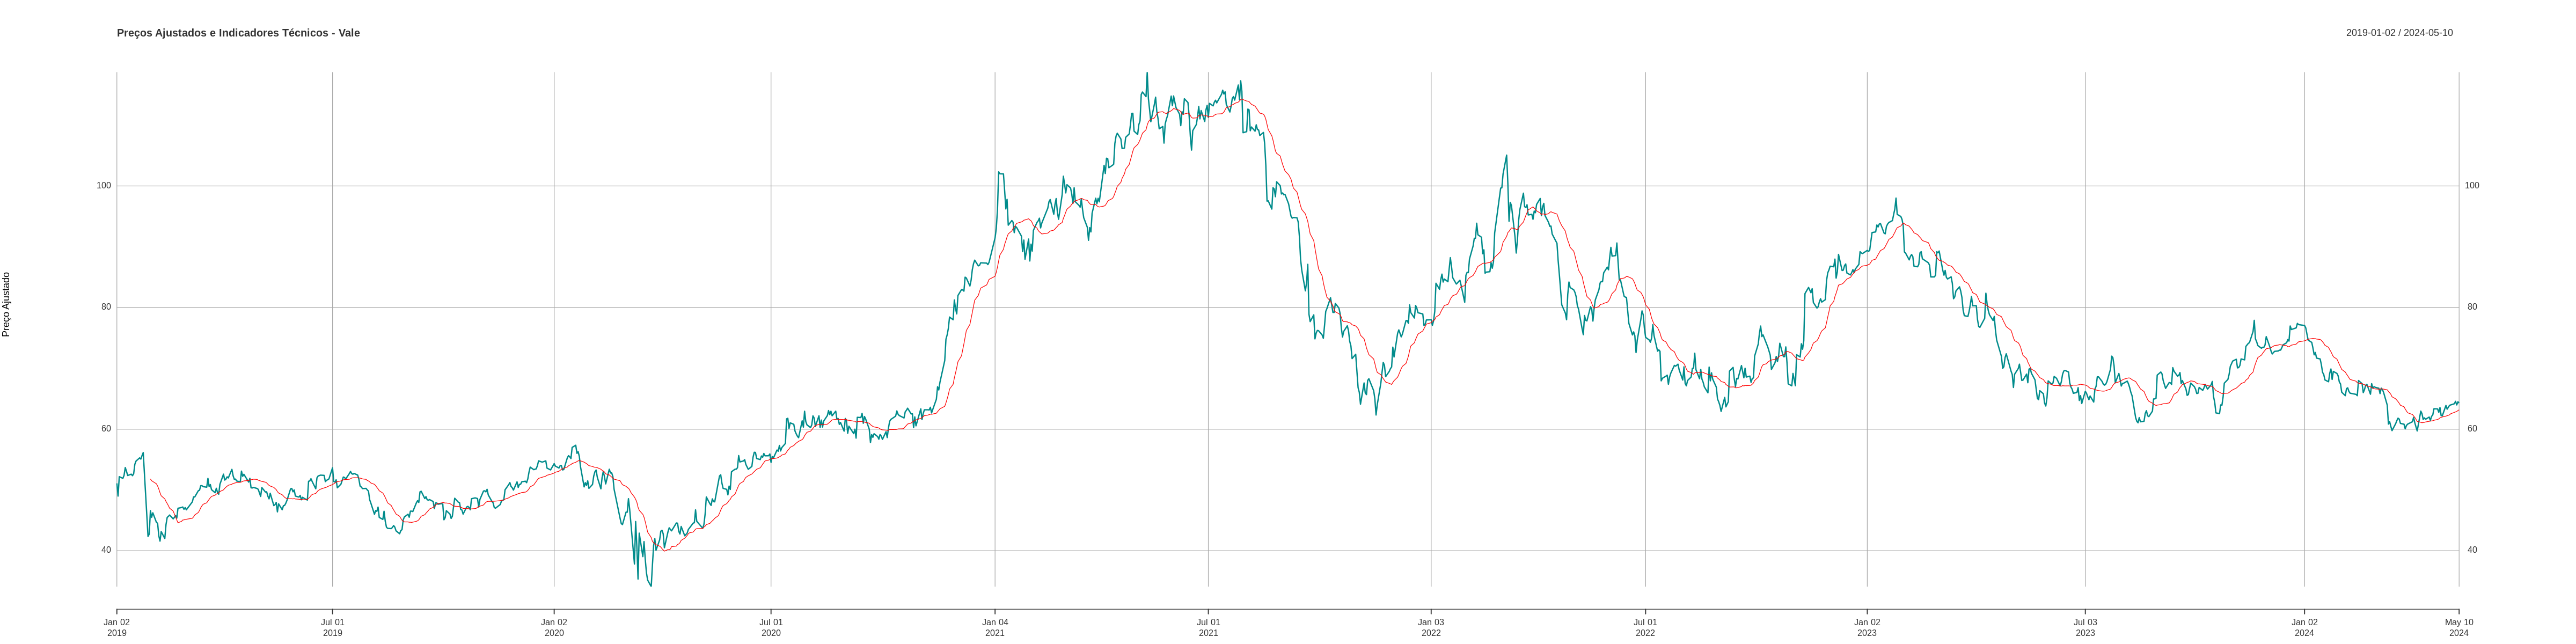

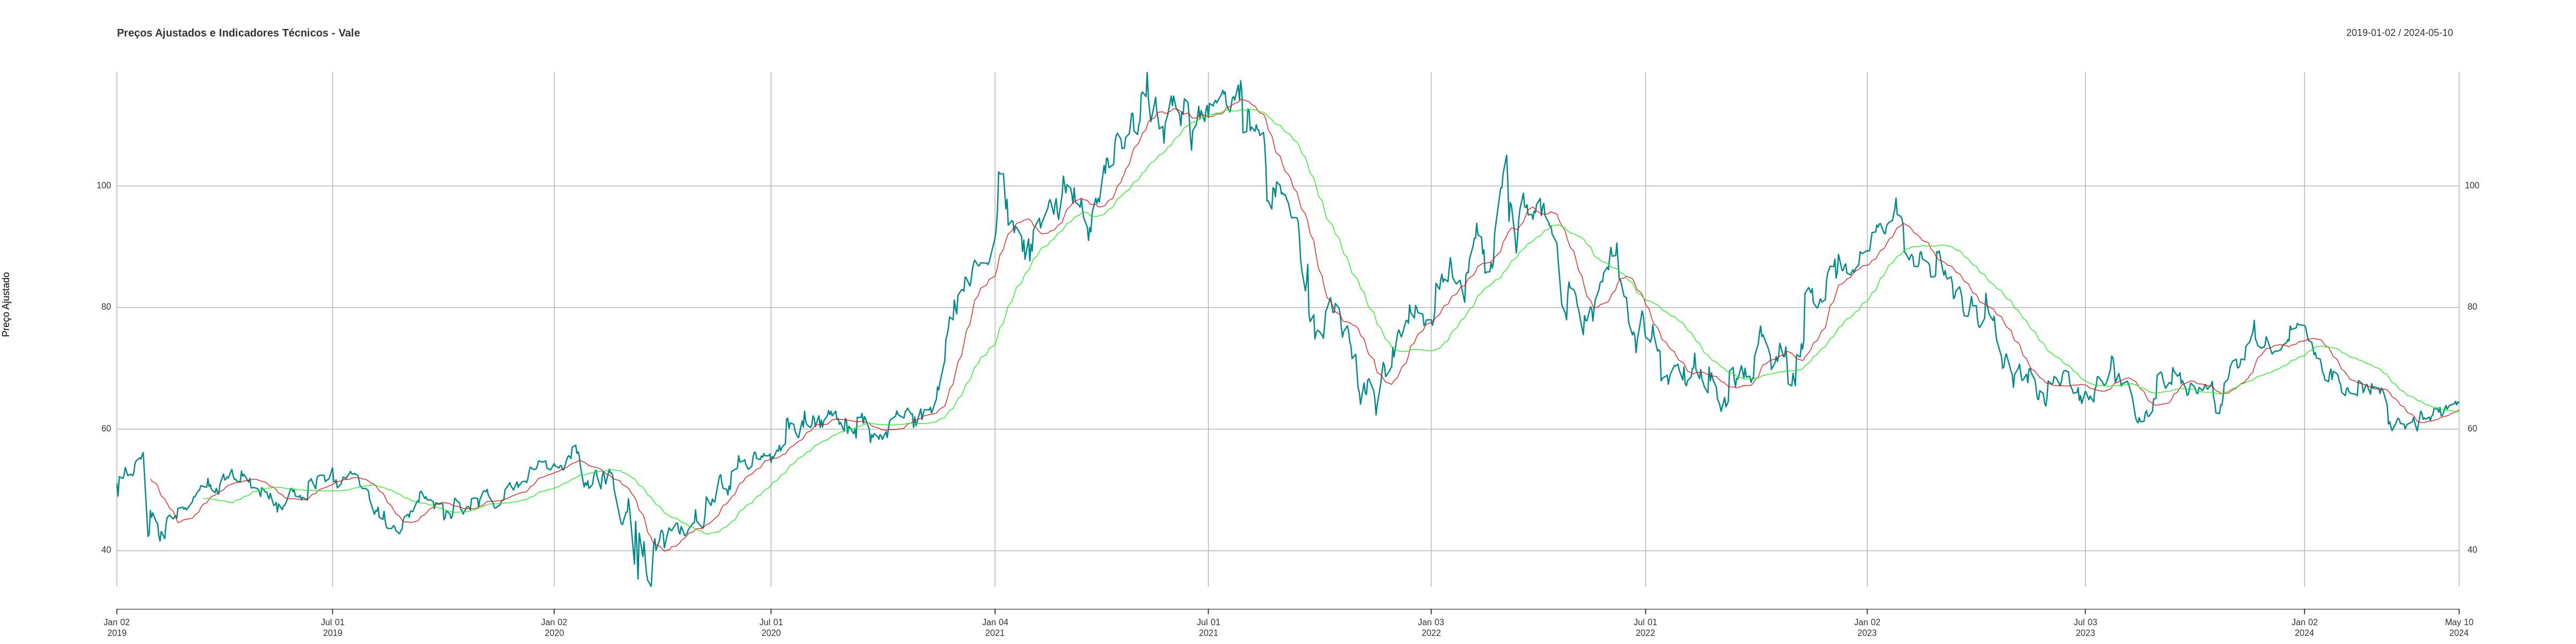

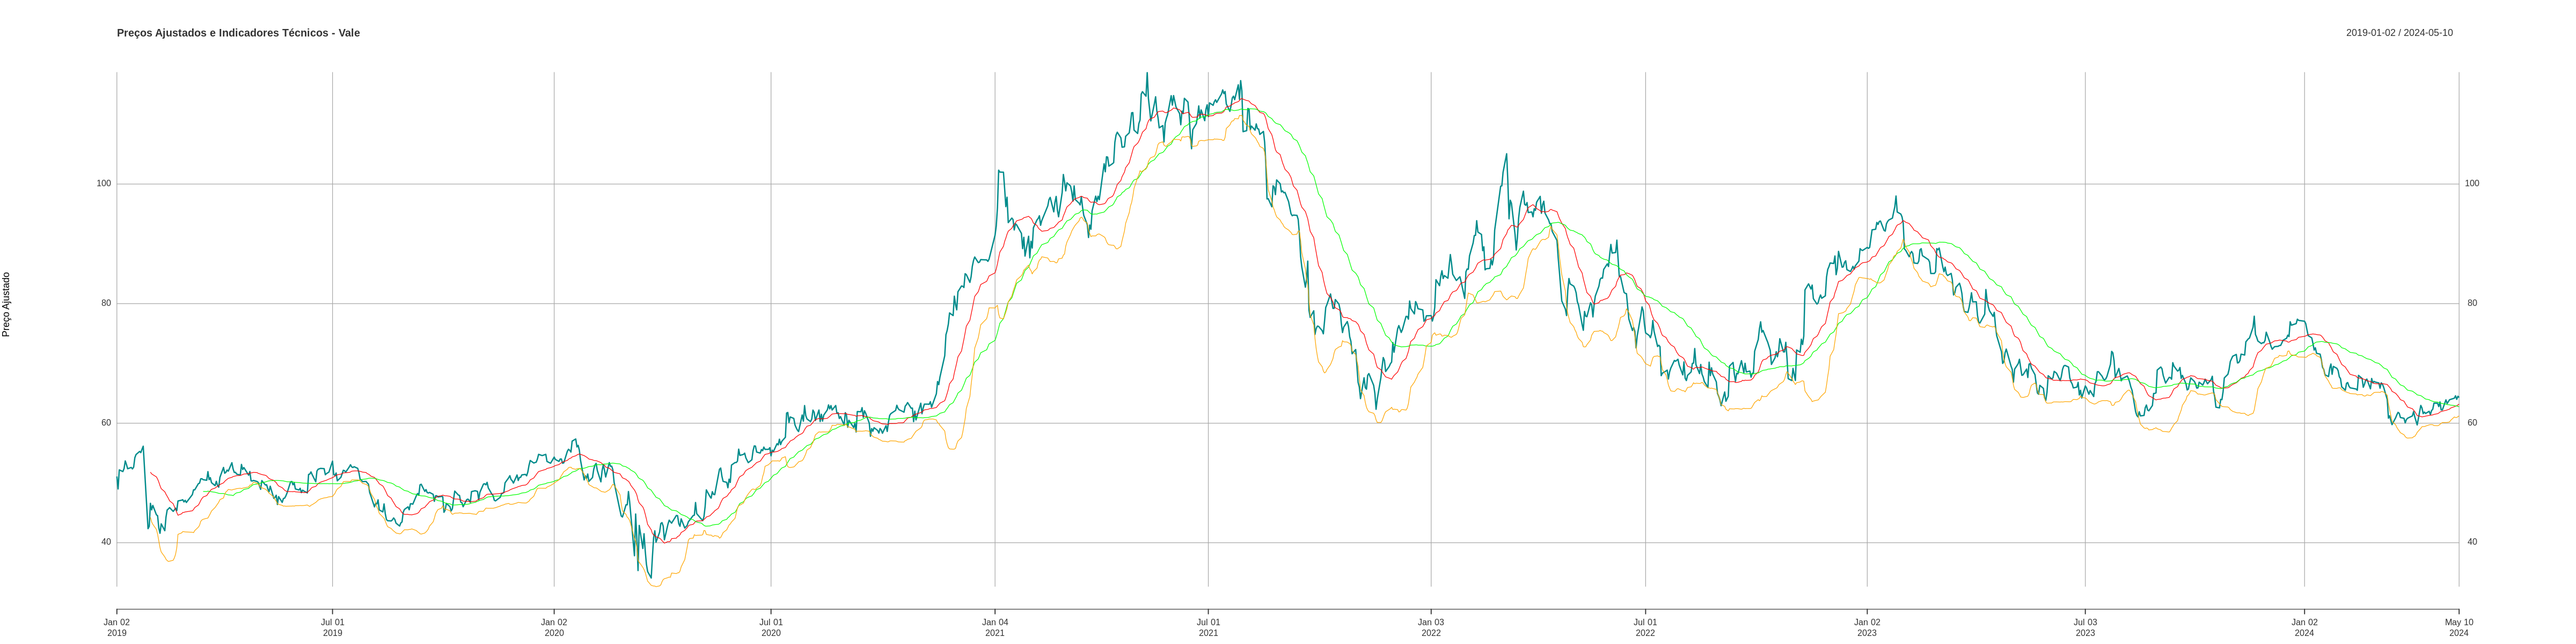

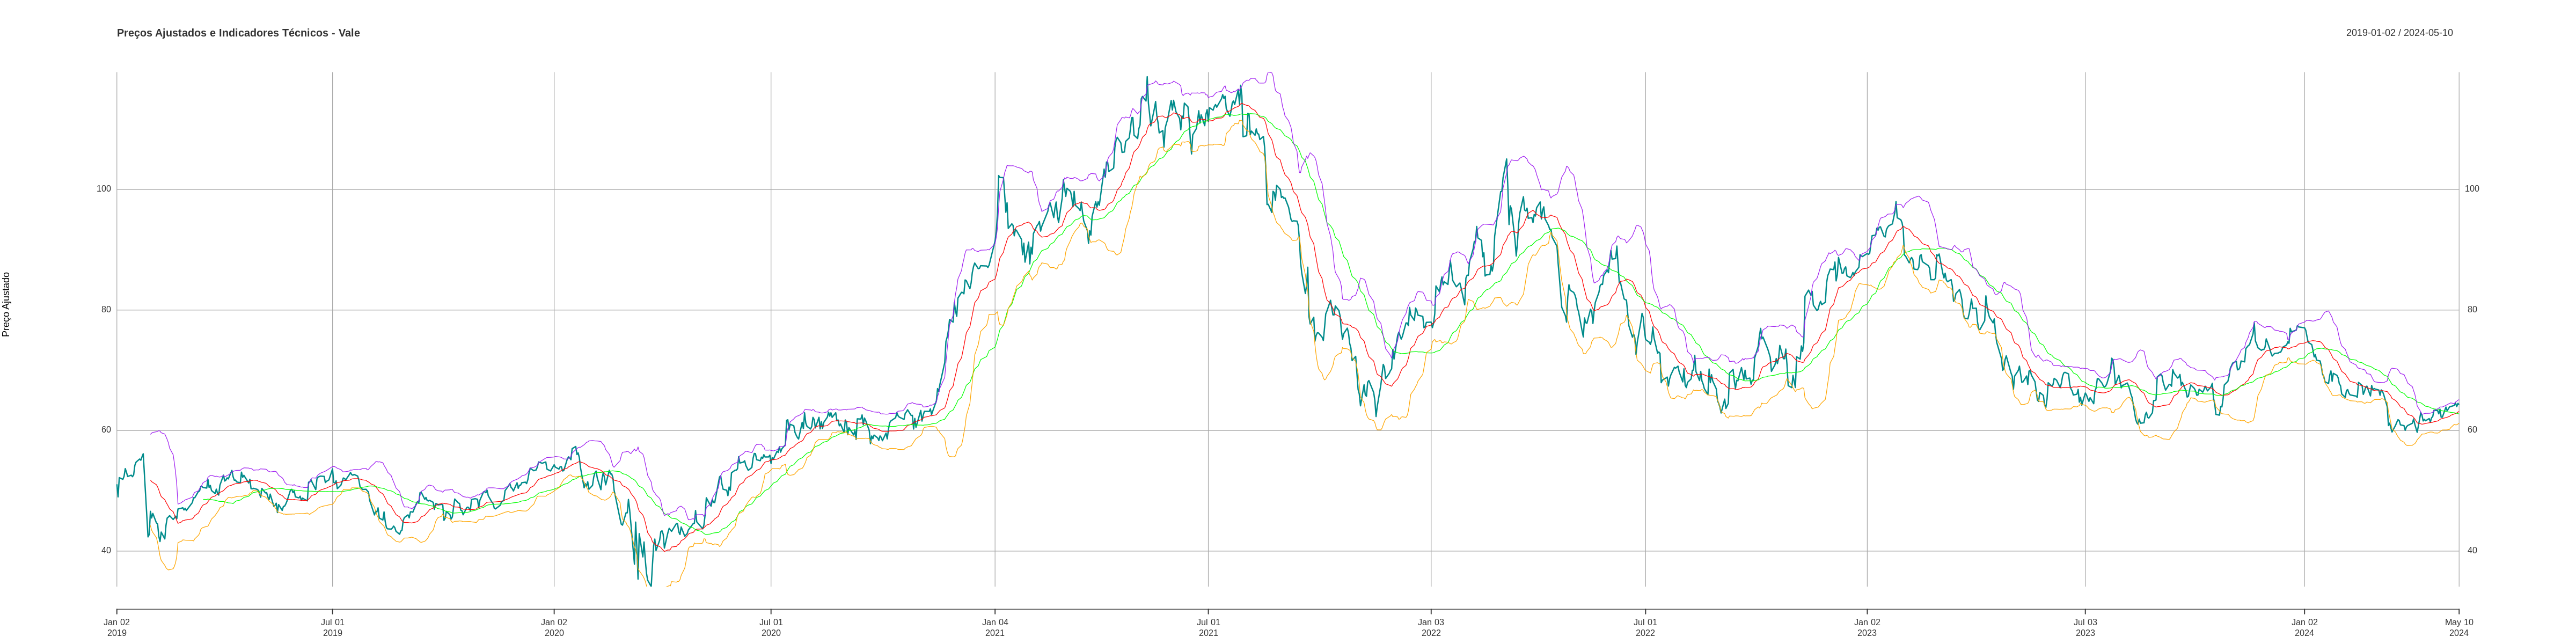

In [14]:
# Plotando os preços ajustados com médias móveis e envelopes de Bollinger - Vale
plot(precos_ajustados, type = "l", col = "cyan4", main = "Preços Ajustados e Indicadores Técnicos - Vale",
     ylab = "Preço Ajustado")
lines(VALE3.SA$SMA20, col = "red")
lines(VALE3.SA$SMA50, col = "green")
lines(VALE3.SA$SDB, col = "orange")
lines(VALE3.SA$SDT, col = "purple")

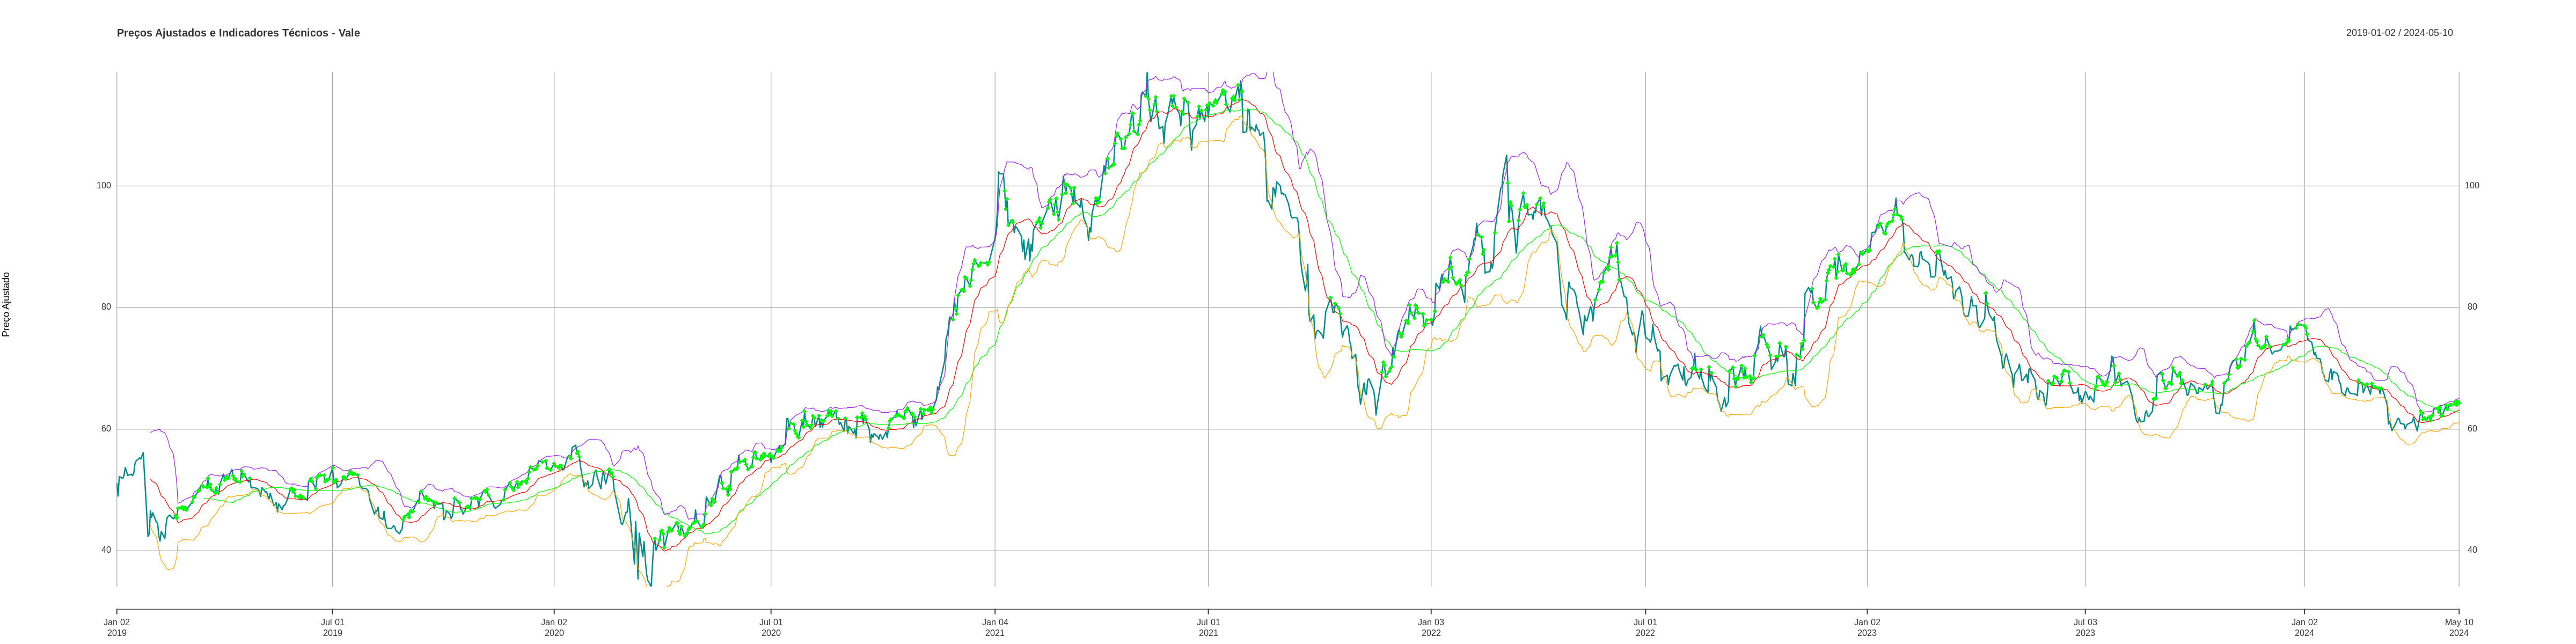

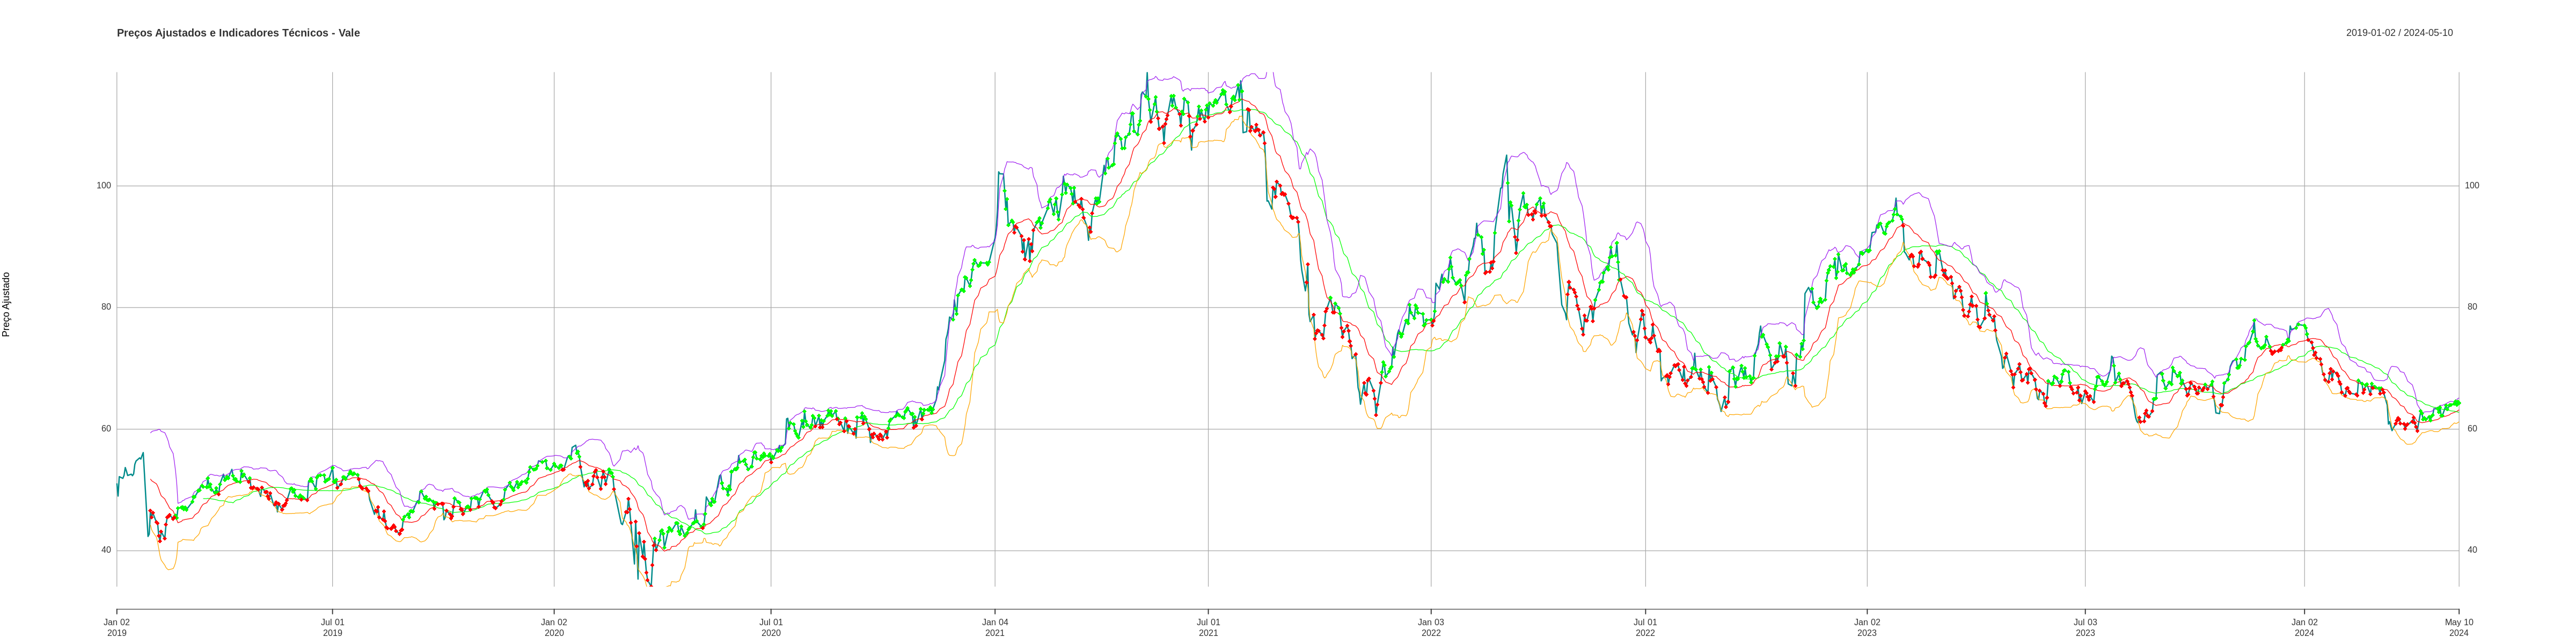

In [15]:
# Adicionando sugestões de compra e venda
# Se o preço cruzar acima da média móvel de curto prazo e estiver abaixo do envelope superior de Bollinger, é um sinal de compra
# Se o preço cruzar abaixo da média móvel de curto prazo e estiver acima do envelope inferior de Bollinger, é um sinal de venda
signals <- rep(NA, length(precos_ajustados))
signals[precos_ajustados > VALE3.SA$SMA20 & precos_ajustados < VALE3.SA$SDT] <- 1  # Compra
signals[precos_ajustados < VALE3.SA$SMA20 & precos_ajustados > VALE3.SA$SDB] <- -1  # Venda
points(precos_ajustados[signals == 1], col = "green", pch = 18)
points(precos_ajustados[signals == -1], col = "red", pch = 18)

# **Análise dos gráficos de candlestick**

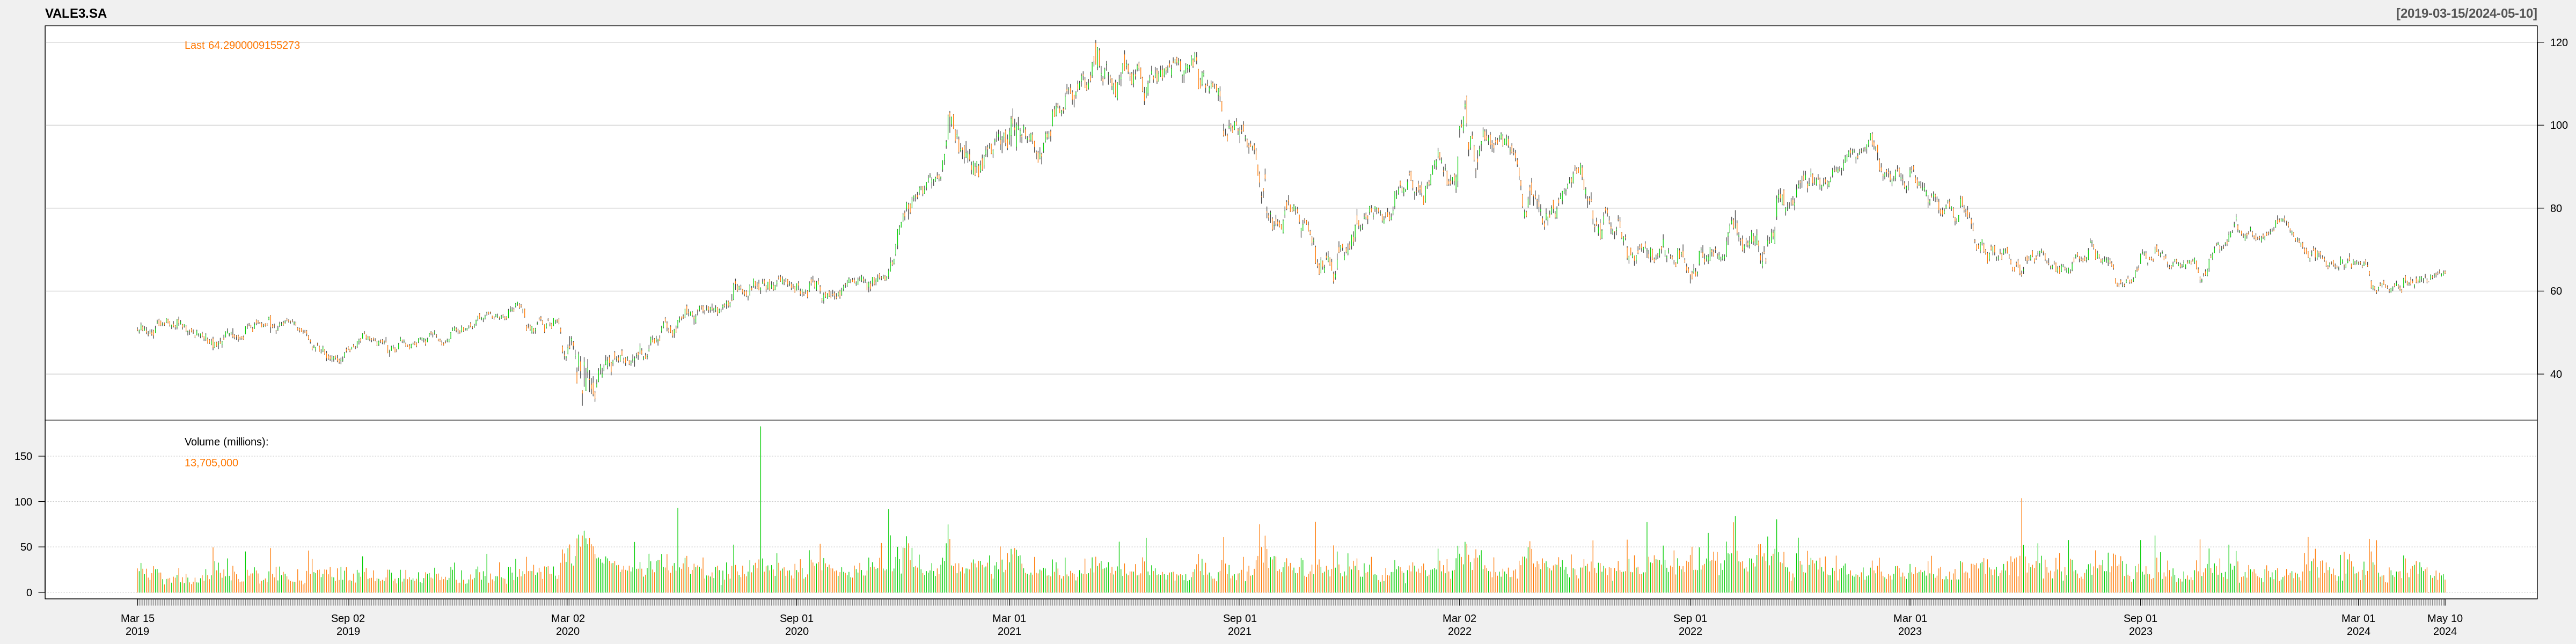

In [16]:
# Criar gráfico de candlestick para o período de 6 anos
chartSeries(VALE3.SA, theme = "white", subset = 'last 6 year')

As Bandas de Bollinger são um indicador técnico popular desenvolvido por John Bollinger na década de 1980. Elas são compostas por três linhas:


*   **Média Móvel Simples (MM):** A linha do meio é uma média móvel simples de um determinado período, geralmente 20 períodos por padrão. Esta linha representa a tendência de médio prazo do ativo.
*   **Banda Superior:** É uma linha que fica acima da média móvel e é calculada adicionando duas vezes o desvio padrão da média móvel simples ao longo do mesmo período da média móvel. A banda superior representa a faixa de volatilidade esperada para o ativo. Ela tende a se expandir quando a volatilidade aumenta e se contrair quando a volatilidade diminui.
*   **Banda Inferior:** É uma linha que fica abaixo da média móvel e é calculada subtraindo duas vezes o desvio padrão da média móvel simples ao longo do mesmo período da média móvel. A banda inferior também representa a faixa de volatilidade esperada para o ativo.

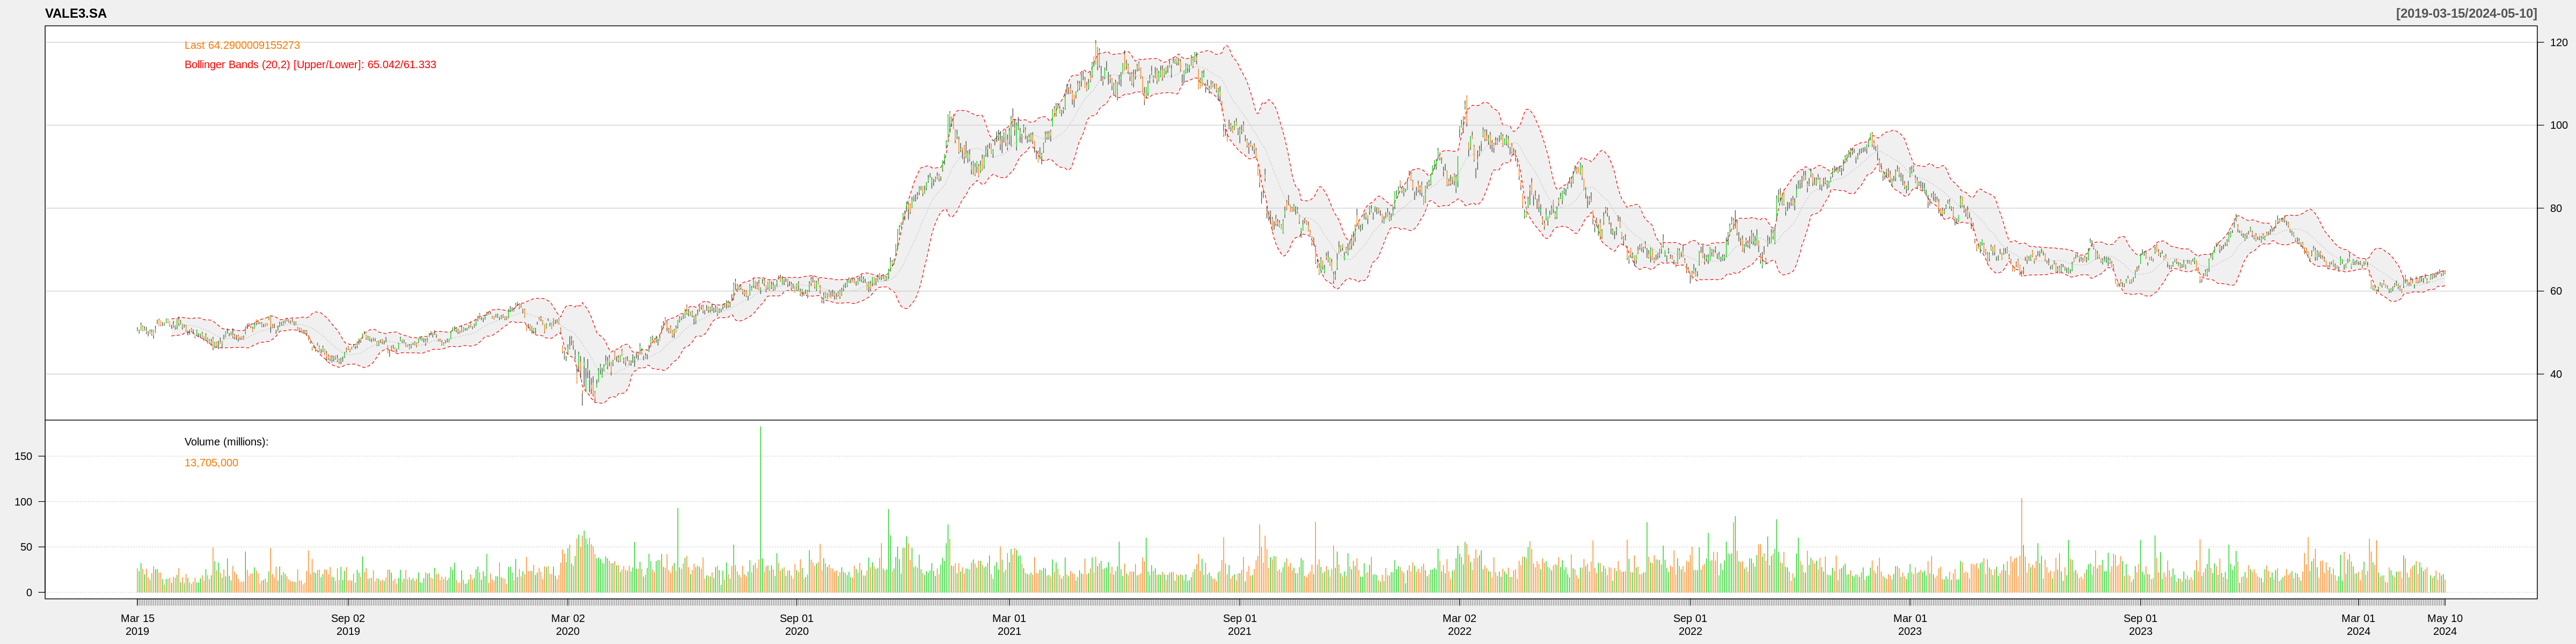

In [17]:
# Adicionar indicadores técnicos
addBBands()

A função addSMA() é usada no pacote quantmod do R para adicionar linhas de médias móveis simples (SMA) a um gráfico de séries temporais. SMA é um indicador técnico que suaviza os dados de preços de um ativo financeiro, calculando a média dos preços de fechamento ao longo de um determinado período de tempo. Isso ajuda a visualizar a tendência subjacente dos preços.

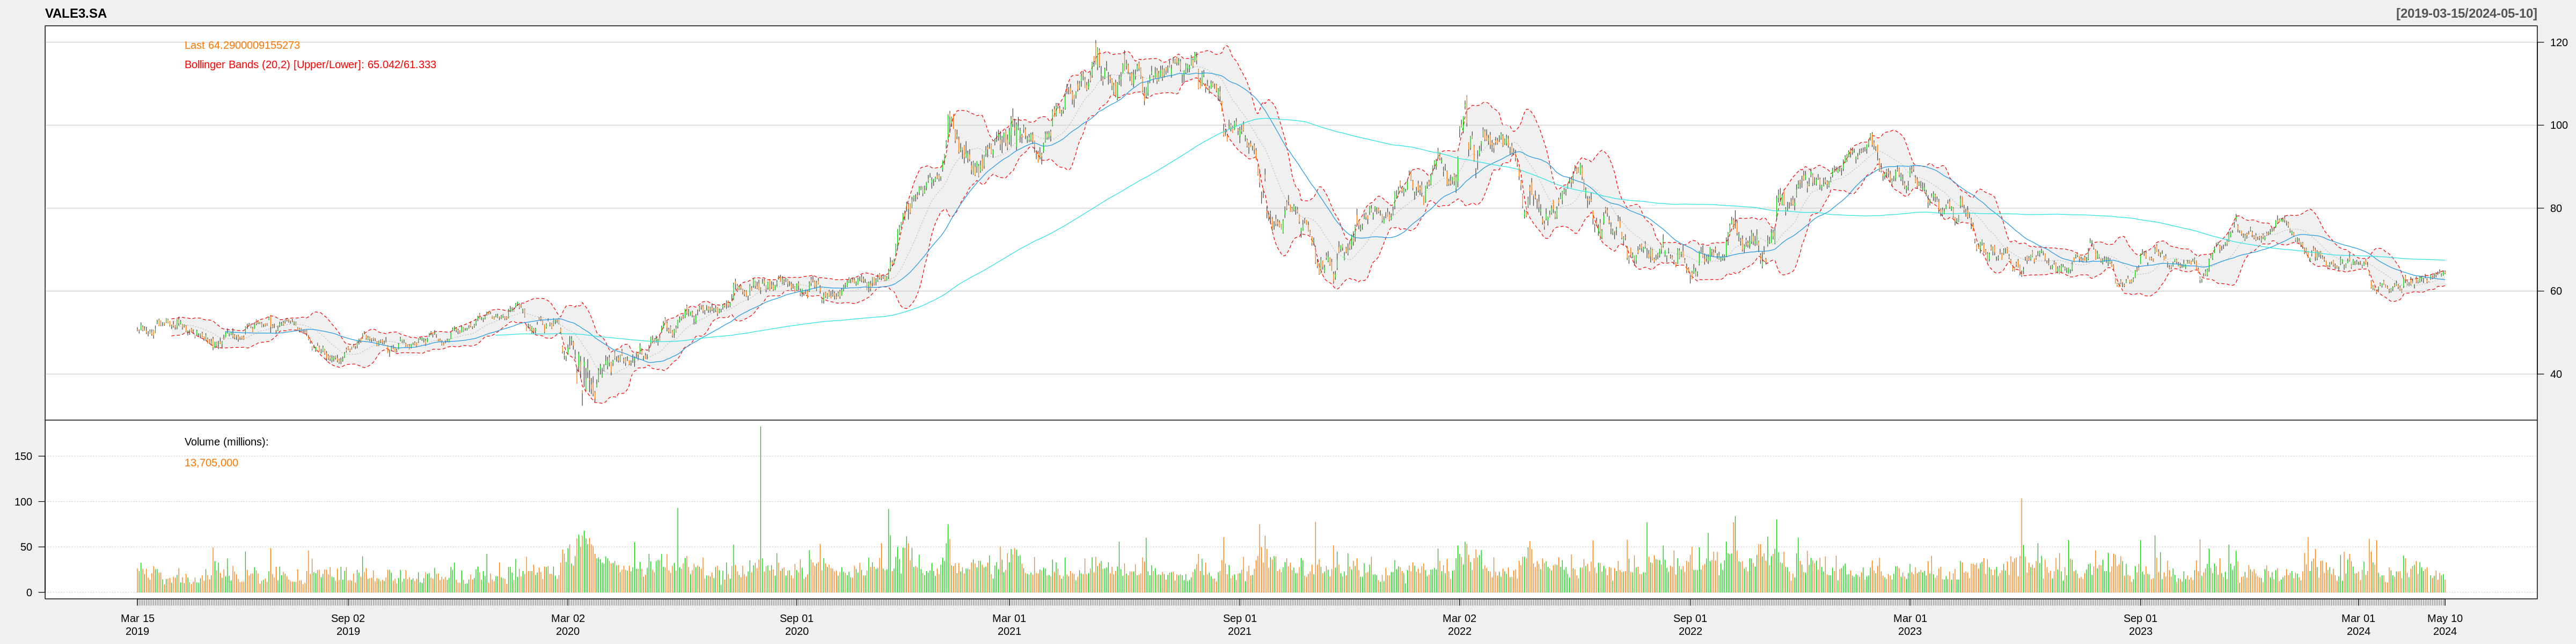

In [18]:
addSMA(n = c(50, 200), on = 1)

A função `addMACD()` é usada no pacote `quantmod` do R para adicionar o indicador MACD (Moving Average Convergence Divergence) a um gráfico de séries temporais. O MACD é um indicador de momentum que ajuda os traders e investidores a identificar a direção e a força das tendências dos preços.

MACD é calculado subtraindo a média móvel exponencial de longo prazo (geralmente 26 períodos) da média móvel exponencial de curto prazo (geralmente 12 períodos). O resultado dessa subtração é conhecido como linha MACD. Além disso, uma média móvel exponencial (geralmente com um período de 9) do próprio MACD é calculada para criar a linha de sinal.

A função `addMACD()` adiciona três linhas ao gráfico:

1. **Linha MACD:** Representa a diferença entre a média móvel exponencial de curto prazo e a média móvel exponencial de longo prazo.
2. **Linha de Sinal:** É a média móvel exponencial da linha MACD.
3. **Histograma:** É a diferença entre a linha MACD e a linha de sinal. O histograma é útil para visualizar a convergência e divergência entre as duas linhas, o que pode sinalizar mudanças na direção da tendência.

Essas três linhas do indicador MACD podem ser usadas para identificar pontos de virada potenciais no mercado, bem como para confirmar a força e a direção das tendências dos preços. Quando a linha MACD cruza acima da linha de sinal, é geralmente considerado um sinal de compra (bullish), enquanto que quando a linha MACD cruza abaixo da linha de sinal, é geralmente considerado um sinal de venda (bearish). O histograma também pode ser usado para confirmar esses sinais, conforme mostra a convergência ou divergência entre as duas linhas.

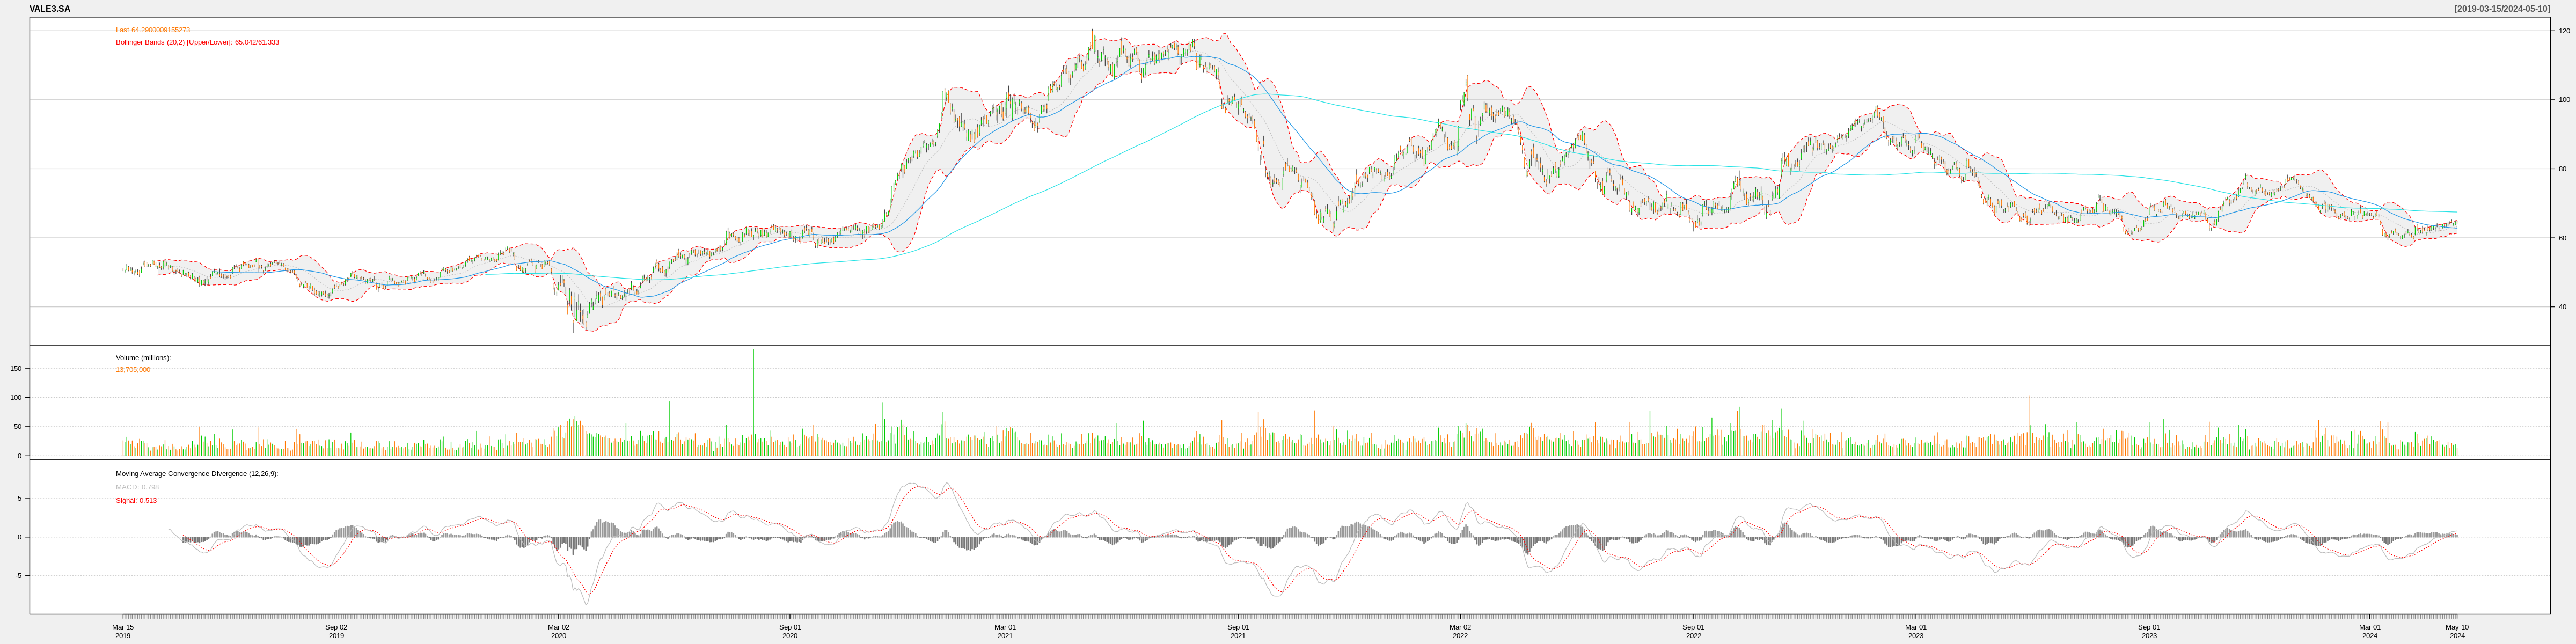

In [19]:
addMACD()

# **Utilizando o Gemini do Google para buscar informações relevantes sobre as ações da empresa analisada**
O Google Gemini é uma LLM (Large Language Model) e a mais recente e avançada família de modelos de inteligência artificial generativa da Google.

O Gemini é um recurso muito interessante para buscar informações sobre diversos assuntos, e nesse caso, informações relevantes sobre as ações de uma empresa.

Para criar uma API do Google AI Studio e integrar ao código, acesse o site: https://ai.google.dev/gemini-api/docs/api-key?hl=pt-br


Mais informações:

https://blog.google/intl/pt-br/novidades/tecnologia/apresentando-o-gemini-nosso-maior-e-mais-habil-modelo-de-ia/#mensagem-sundar

https://www.alura.com.br/artigos/google-gemini

---


**Exemplos de comandos:**

1.   Realize uma análise detalhada das açõesda empresa VALE.SA desde de Janeiro de 2019 até o momento atual, correlacione com as notícias veiculadas na mídia e informe quais os melhores momentos para realizar um investimento.
2.   Quais os melhores momentos para investir nas ações da VALE.SA?


---

In [53]:
prompt <- readline("Introduza um comando aqui:  ")

cat ("\n")

cat(gemini(prompt))


Introduza um comando aqui:  Realize uma análise detalhada das açõesda empresa VALE.SA desde de Janeiro de 2019 até o momento atual, correlacione com as notícias veiculadas na mídia e informe quais os melhores momentos para realizar um investimento.
**Análise das Ações da VALE.SA de Janeiro de 2019 ao Presente**

**Desempenho das Ações**

Desde janeiro de 2019, as ações da Vale (VALE.SA) apresentaram uma trajetória volátil, marcada por altos e baixos significativos.

* **Janeiro de 2019:** As ações iniciaram o ano em torno de R$ 50,00.
* **Fevereiro de 2021:** Alcançaram sua máxima histórica de R$ 115,00.
* **Março de 2023:** Estão sendo negociadas em torno de R$ 80,00.

**Eventos Relevantes**

Vários eventos significativos influenciaram o desempenho das ações da Vale ao longo deste período:

* **Rompimento da Barragem de Brumadinho (2019):** O desastre ambiental resultou em uma queda significativa no preço das ações.
* **Guerra Comercial EUA-China (2019-2021):** A desaceleração econôm



---


*IMPORTANTE DESTACAR QUE AS INFORMAÇÕES AQUI APRESENTADAS, NÃO SÃO RECOMENDAÇÕES DE INVESTIMENTO. É NECESSÁRIO REALIZAR UMA ANÁLISE APROFUNDDADA E CONSIDERAR DIVERSOS FATORES ANTES DE INVESTIR.*